**PREPROCESSING:**

In [ ]:
import pandas as pd
import numpy as np

import datetime
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

**IMPORTING DATASETS:**

In [ ]:
events_df = pd.read_csv('/content/events.csv')
category_tree_df = pd.read_csv('/content/category_tree.csv')
item_properties_1_df = pd.read_csv('/content/item_properties_part1.csv')
item_properties_2_df = pd.read_csv('/content/item_properties_part2.csv')

In [ ]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [ ]:
events_df[events_df.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [ ]:
events_df[events_df.transactionid.isnull()].event.unique()

array(['view', 'addtocart'], dtype=object)

In [ ]:
item_properties_1_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [ ]:
item_properties_1_df.loc[(item_properties_1_df.property == 'categoryid') & (item_properties_1_df.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
6363096,1431226800000,339403,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
7942027,1431226800000,418837,categoryid,1016
10230975,1431226800000,85538,categoryid,1016
7280176,1431226800000,278463,categoryid,1016


In [ ]:
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [ ]:
all_customers = events_df.visitorid.unique()
all_customers.size

1407580

In [ ]:
customer_browsed = [x for x in all_customers if x not in customer_purchased]

In [ ]:
len(customer_browsed)

1395861

In [ ]:
temp_array = np.isin(customer_browsed, customer_purchased)
temp_array[temp_array == False].size

1395861

In [ ]:
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787])

In [ ]:
events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


In [ ]:
tz = int('1433221332')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-06-02 05:02:12'

In [ ]:
tz = int('1438400163')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-08-01 03:36:03'

In [ ]:
# Firstly let's create an array that lists visitors who made a purchase
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()

purchased_items = []

# Create another list that contains all their purchases
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values))

In [ ]:
purchased_items[:5]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044]]

In [ ]:
# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):

    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x

    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))

    return recommender_list

In [ ]:
recommender_bought_bought(302422, purchased_items)

[105792, 200793, 12836, 80582, 380775, 15335, 400969, 25353, 237753, 317178]

In [ ]:
all_visitors = events_df.visitorid.sort_values().unique()
all_visitors.size

1407580

In [ ]:
buying_visitors = events_df[events_df.event == 'transaction'].visitorid.sort_values().unique()
buying_visitors.size

11719

In [ ]:
viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))


In [ ]:
def create_dataframe(visitor_list):

    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = events_df[events_df.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)

    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

In [ ]:
buying_visitors_df = create_dataframe(buying_visitors)

In [ ]:
buying_visitors_df.shape

(11719, 5)

In [ ]:
import random
random.shuffle(viewing_visitors_list)

In [ ]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27820])

In [ ]:
viewing_visitors_df.shape

(27820, 5)

In [ ]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [ ]:
main_df = main_df.sample(frac=1)

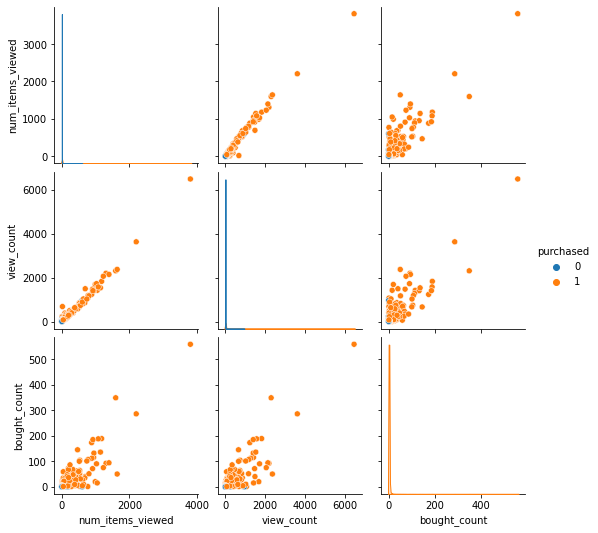

In [ ]:
sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],
             y_vars = ['num_items_viewed', 'view_count', 'bought_count'],  hue = 'purchased')

In [ ]:
X = main_df.drop(['purchased', 'visitorid', 'bought_count'], axis = 'columns')
y = main_df.purchased

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_class = logreg.predict(X_test)

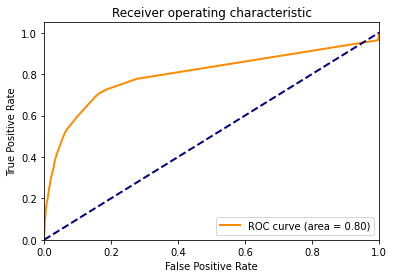

In [ ]:
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

**PERFORMACE METRICS:**

In [ ]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.7921
